<a href="https://colab.research.google.com/github/zuulaika/Projet-python/blob/main/Criminalit%C3%A9_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Taux de Criminalité 2019 vs 2024

In [1]:
!pip install cartiflette


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 4.3 MB/s eta 0:00:00


Reprojeter les données en Lambert 93 (EPSG: 2154) (Le Lambert 93 a été conçu pour être le moins déformant possible sur la France métropolitaine).

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from geo_utils import load_and_reproject_departements

departements_lambert93 = load_and_reproject_departements()


In [5]:
#Préparer les données de criminalité pour le calcul de la moyenne
url = "https://www.data.gouv.fr/fr/datasets/r/8debb975-02da-4bfc-808f-42d18ad76d0b"
df = pd.read_csv(url, sep=';', dtype=str)



In [37]:
# Affiche les valeurs uniques de la colonne 'indicateur' pour voir les types de crimes disponibles.
print(df['indicateur'].unique())

['Homicides' "Tentatives d'homicides" 'Coups et blessures volontaires'
 'Coups et blessures volontaires intrafamiliaux'
 'Autres coups et blessures volontaires' 'Violences sexuelles'
 'Vols avec armes' 'Vols violents sans arme'
 'Vols sans violence contre des personnes' 'Cambriolages de logement'
 'Vols de véhicules' 'Vols dans les véhicules'
 "Vols d'accessoires sur véhicules"
 'Destructions et dégradations volontaires' 'Usage de stupéfiants'
 'Usage de stupéfiants (AFD)' 'Trafic de stupéfiants' 'Escroqueries']


In [6]:
#On définit des poids à chaque type de crime selon a gravité

crime_weights = {
    'Homicides': 10,
    "Tentatives d'homicides": 9,
    'Coups et blessures volontaires': 5,
    'Coups et blessures volontaires intrafamiliaux': 6,
    'Autres coups et blessures volontaires': 4,
    'Violences sexuelles': 8,
    'Vols avec armes': 7,
    'Vols violents sans arme': 6,
    'Vols sans violence contre des personnes': 3,
    'Cambriolages de logement': 5,
    'Vols de véhicules': 4,
    'Vols dans les véhicules': 2,
    "Vols d'accessoires sur véhicules": 2,
    'Destructions et dégradations volontaires': 3,
    'Usage de stupéfiants': 1,
    'Usage de stupéfiants (AFD)': 1,
    'Trafic de stupéfiants': 5,
    'Escroqueries': 3
}

print("Crime weights dictionary created:")
print(crime_weights)

Crime weights dictionary created:
{'Homicides': 10, "Tentatives d'homicides": 9, 'Coups et blessures volontaires': 5, 'Coups et blessures volontaires intrafamiliaux': 6, 'Autres coups et blessures volontaires': 4, 'Violences sexuelles': 8, 'Vols avec armes': 7, 'Vols violents sans arme': 6, 'Vols sans violence contre des personnes': 3, 'Cambriolages de logement': 5, 'Vols de véhicules': 4, 'Vols dans les véhicules': 2, "Vols d'accessoires sur véhicules": 2, 'Destructions et dégradations volontaires': 3, 'Usage de stupéfiants': 1, 'Usage de stupéfiants (AFD)': 1, 'Trafic de stupéfiants': 5, 'Escroqueries': 3}


In [7]:
# Convertit la colonne 'taux_pour_mille' en float, en remplaçant les virgules par des points.
df['taux_pour_mille'] = df['taux_pour_mille'].str.replace(',', '.', regex=False).astype(float)
# Assigne un poids à chaque type de crime basé sur le dictionnaire 'crime_weights'.
df['weight'] = df['indicateur'].map(crime_weights)
# Calcule le taux de criminalité pondéré en multipliant le taux par le poids.
df['weighted_taux_pour_mille'] = df['taux_pour_mille'] * df['weight']

# Somme les incidents pondérés par département et par année pour obtenir un indice de criminalité.
weighted_crime_index = df.groupby(['Code_departement', 'annee'])['weighted_taux_pour_mille'].sum().reset_index()

print("Premières lignes de l'indice de criminalité pondéré :")
print(weighted_crime_index.head())
print("\nInformations sur l'indice de criminalité pondéré :")
print(weighted_crime_index.info())

Premières lignes de l'indice de criminalité pondéré :
  Code_departement annee  weighted_taux_pour_mille
0               01  2016                130.893972
1               01  2017                131.861979
2               01  2018                136.442044
3               01  2019                144.930362
4               01  2020                122.548290

Informations sur l'indice de criminalité pondéré :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 909 entries, 0 to 908
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Code_departement          909 non-null    object 
 1   annee                     909 non-null    object 
 2   weighted_taux_pour_mille  909 non-null    float64
dtypes: float64(1), object(2)
memory usage: 21.4+ KB
None


In [8]:
# Filtre l'indice de criminalité pondéré pour les années 2019 et 2024.
weighted_crime_index_2019 = weighted_crime_index[weighted_crime_index['annee'] == '2019']
weighted_crime_index_2024 = weighted_crime_index[weighted_crime_index['annee'] == '2024']

# Fusionne les données géographiques des départements avec l'indice de criminalité pondéré pour 2019.
merged_weighted_crime_2019 = departements_lambert93.merge(weighted_crime_index_2019, left_on='INSEE_DEP', right_on='Code_departement', how='left')
# Fusionne les données géographiques des départements avec l'indice de criminalité pondéré pour 2024.
merged_weighted_crime_2024 = departements_lambert93.merge(weighted_crime_index_2024, left_on='INSEE_DEP', right_on='Code_departement', how='left')

print("Premières lignes des données fusionnées pour 2019 :")
print(merged_weighted_crime_2019.head())
print("\nInformations sur les données fusionnées pour 2019 :")
print(merged_weighted_crime_2019.info())

print("\nPremières lignes des données fusionnées pour 2024 :")
print(merged_weighted_crime_2024.head())
print("\nInformations sur les données fusionnées pour 2024 :")
print(merged_weighted_crime_2024.info())

Premières lignes des données fusionnées pour 2019 :
  INSEE_DEP    PAYS LIBELLE_DEPARTEMENT  POPULATION  \
0        43  France         Haute-Loire      227570   
1        65  France     Hautes-Pyrénées      229567   
2        29  France           Finistère      915090   
3        22  France       Côtes-d'Armor      600582   
4        38  France               Isère     1271166   

                             SOURCE  \
0  IGN:EXPRESS-COG-CARTO-TERRITOIRE   
1  IGN:EXPRESS-COG-CARTO-TERRITOIRE   
2  IGN:EXPRESS-COG-CARTO-TERRITOIRE   
3  IGN:EXPRESS-COG-CARTO-TERRITOIRE   
4  IGN:EXPRESS-COG-CARTO-TERRITOIRE   

                                            geometry Code_departement annee  \
0  POLYGON ((770266.6 6473465.6, 770255.9 6473419...               43  2019   
1  MULTIPOLYGON (((449840.3 6280811.2, 449889.1 6...               65  2019   
2  MULTIPOLYGON (((177277.8 6756845.8, 177266.5 6...               29  2019   
3  MULTIPOLYGON (((245287.3 6878865.1, 245276.3 6...              

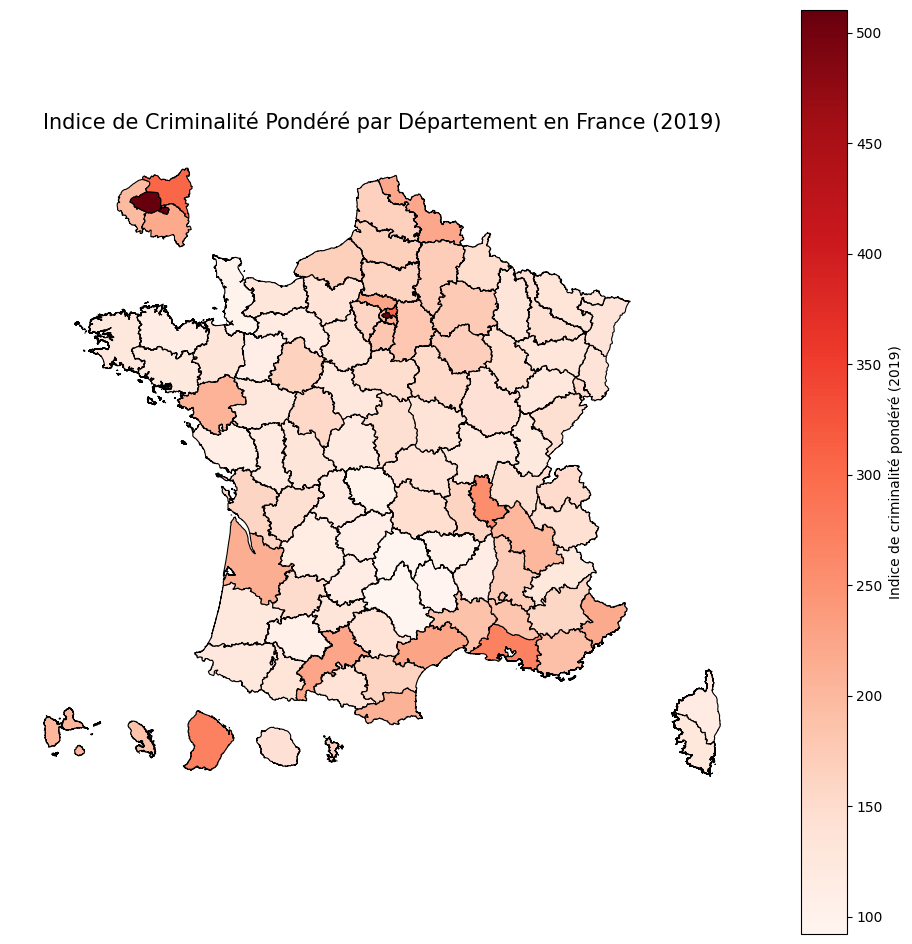

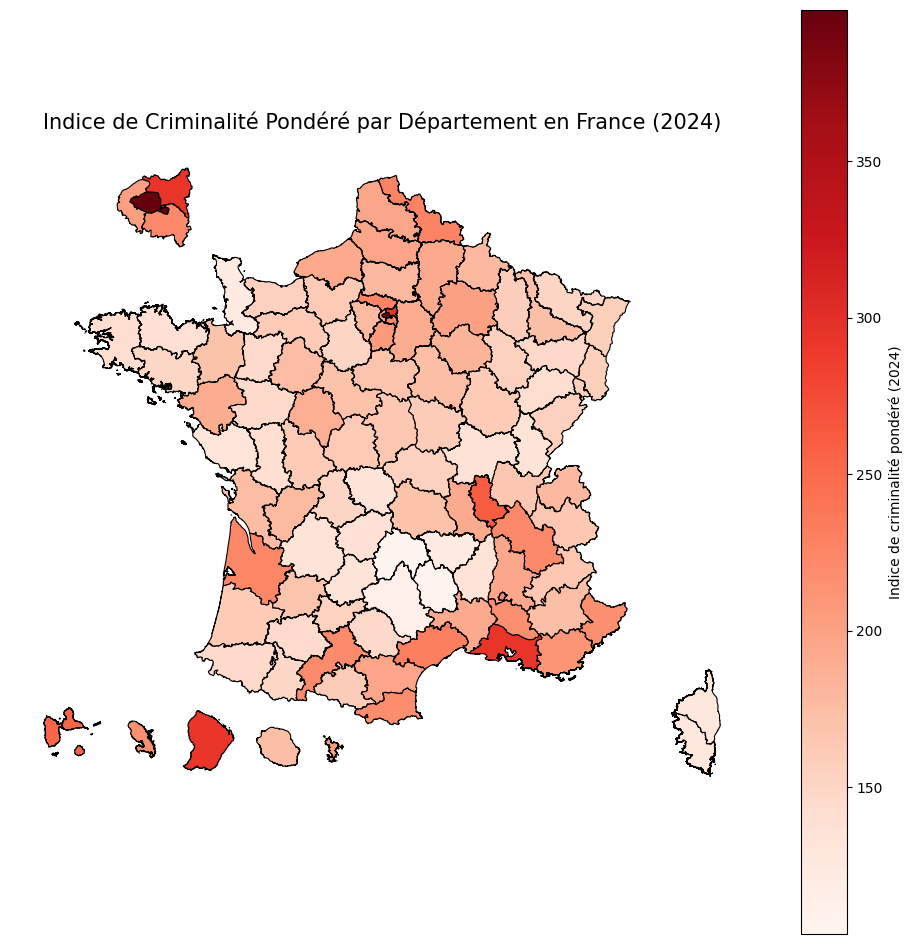

In [9]:
import matplotlib.pyplot as plt

# Plot for 2019 weighted crime index
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
merged_weighted_crime_2019.plot(
    column='weighted_taux_pour_mille',
    cmap='Reds',
    linewidth=0.8,
    ax=ax,
    edgecolor='black',
    legend=True,
    legend_kwds={'label': "Indice de criminalité pondéré (2019)"}
)
ax.set_title("Indice de Criminalité Pondéré par Département en France (2019)", fontsize=15)
ax.set_axis_off()
plt.show()

# Plot for 2024 weighted crime index
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
merged_weighted_crime_2024.plot(
    column='weighted_taux_pour_mille',
    cmap='Reds',
    linewidth=0.8,
    ax=ax,
    edgecolor='black',
    legend=True,
    legend_kwds={'label': "Indice de criminalité pondéré (2024)"}
)
ax.set_title("Indice de Criminalité Pondéré par Département en France (2024)", fontsize=15)
ax.set_axis_off()
plt.show()

In [10]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Sélectionne les caractéristiques pertinentes pour le clustering à partir des données de 2019.
# Nous utilisons 'weighted_taux_pour_mille' (indice de criminalité pondéré) et 'POPULATION'.
features_2019 = merged_weighted_crime_2019[['weighted_taux_pour_mille', 'POPULATION']].copy()

# Vérifie les valeurs manquantes avant la mise à l'échelle.
print("Valeurs manquantes dans les caractéristiques 2019 :\n", features_2019.isnull().sum())

# Effectue la mise à l'échelle des caractéristiques à l'aide de StandardScaler.
# Cela garantit que chaque caractéristique contribue de manière égale à la formation des clusters.
scaler = StandardScaler()
scaled_features_2019 = scaler.fit_transform(features_2019)

# Convertit les caractéristiques mises à l'échelle en un DataFrame pour une meilleure lisibilité.
scaled_features_df_2019 = pd.DataFrame(
    scaled_features_2019,
    columns=features_2019.columns,
    index=features_2019.index
)

print('\nPremières 5 lignes des caractéristiques mises à l\'échelle pour 2019 :')
display(scaled_features_df_2019.head())

Valeurs manquantes dans les caractéristiques 2019 :
 weighted_taux_pour_mille    0
POPULATION                  0
dtype: int64

Premières 5 lignes des caractéristiques mises à l'échelle pour 2019 :


,weighted_taux_pour_mille,POPULATION
0,-0.941052,-0.882399
1,-0.447224,-0.878713
2,-0.554744,0.386731
3,-0.772657,-0.193836
4,0.609731,1.044031


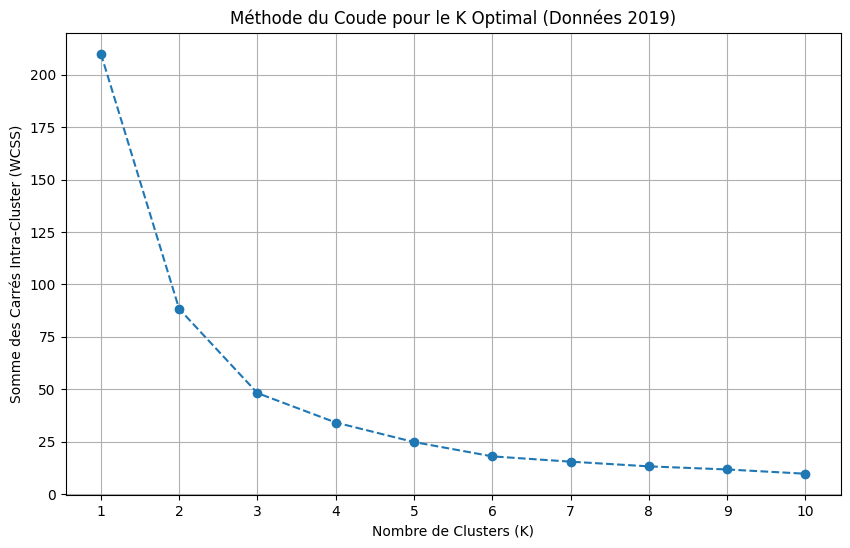

In [11]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Détermine le nombre optimal de clusters (K) à l'aide de la méthode du coude.
wcss = [] # Somme des carrés intra-cluster
k_range = range(1, 11) # Teste k de 1 à 10

for k in k_range:
    # Initialise KMeans avec un nombre de clusters et un état aléatoire pour la reproductibilité.
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    # Entraîne le modèle KMeans sur les caractéristiques mises à l'échelle.
    kmeans.fit(scaled_features_2019)
    # Ajoute la somme des carrés intra-cluster (inertie) à la liste.
    wcss.append(kmeans.inertia_)

# Trace les résultats de la méthode du coude.
plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o', linestyle='--')
plt.title('Méthode du Coude pour le K Optimal (Données 2019)')
plt.xlabel('Nombre de Clusters (K)')
plt.ylabel('Somme des Carrés Intra-Cluster (WCSS)')
plt.xticks(k_range)
plt.grid(True)
plt.show()

Le graphique de la méthode du coude ci-dessus nous aide à déterminer le nombre optimal de clusters (k). Nous recherchons le 'point de coude' où la diminution de la somme des carrés intra-cluster (WCSS) commence à ralentir. Ce point indique souvent un bon équilibre entre le nombre de clusters et la compacité de ceux-ci. On choisit k=4.

In [12]:
from sklearn.cluster import KMeans

k = 4 # Nombre de clusters choisi basé sur la méthode du coude
# Applique l'algorithme K-Means avec le nombre de clusters choisi.
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
# Prédit les clusters pour chaque département et ajoute les étiquettes de cluster au DataFrame.
merged_weighted_crime_2019['cluster'] = kmeans.fit_predict(scaled_features_2019)

print(f"Clustering K-Means appliqué avec {k} clusters.")
print("Premières lignes avec les étiquettes de cluster :")
display(merged_weighted_crime_2019.head())

Clustering K-Means appliqué avec 4 clusters.
Premières lignes avec les étiquettes de cluster :


,INSEE_DEP,PAYS,LIBELLE_DEPARTEMENT,POPULATION,SOURCE,geometry,Code_departement,annee,weighted_taux_pour_mille,cluster
0,43,France,Haute-Loire,227570,IGN:EXPRESS-COG-CARTO-TERRITOIRE,"POLYGON ((770266.6 6473465.6, 770255.9 6473419...",43,2019,102.010163,0
1,65,France,Hautes-Pyrénées,229567,IGN:EXPRESS-COG-CARTO-TERRITOIRE,"MULTIPOLYGON (((449840.3 6280811.2, 449889.1 6...",65,2019,134.125156,0
2,29,France,Finistère,915090,IGN:EXPRESS-COG-CARTO-TERRITOIRE,"MULTIPOLYGON (((177277.8 6756845.8, 177266.5 6...",29,2019,127.132887,3
3,22,France,Côtes-d'Armor,600582,IGN:EXPRESS-COG-CARTO-TERRITOIRE,"MULTIPOLYGON (((245287.3 6878865.1, 245276.3 6...",22,2019,112.961407,0
4,38,France,Isère,1271166,IGN:EXPRESS-COG-CARTO-TERRITOIRE,"POLYGON ((863172.2 6525941.3, 862944.5 6525125...",38,2019,202.861879,1


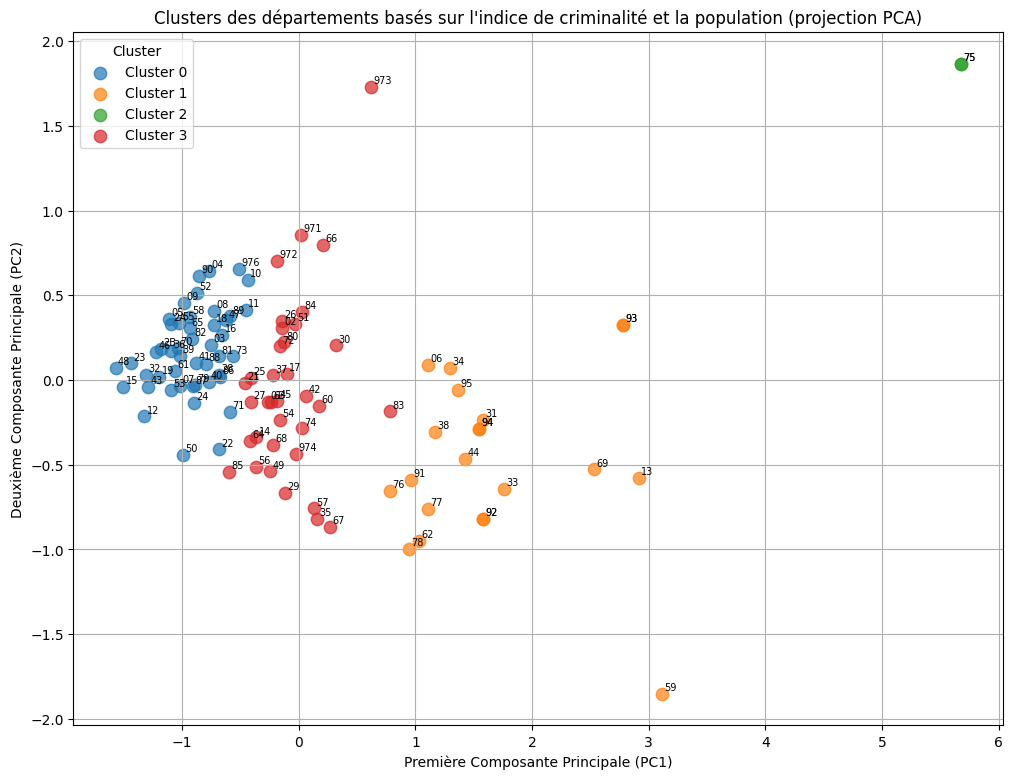

In [13]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Applique la PCA (Analyse en Composantes Principales) pour projeter les données dans un espace 2D.
# Nous utilisons les caractéristiques déjà mises à l'échelle pour le clustering.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(scaled_features_2019)

# Ajoute les deux premières composantes principales (PC1 et PC2) au DataFrame fusionné.
merged_weighted_crime_2019["PC1"] = X_pca[:, 0]
merged_weighted_crime_2019["PC2"] = X_pca[:, 1]

# Visualisation des clusters dans l'espace PCA.
plt.figure(figsize=(12, 9))
# Pour chaque cluster unique, trace les points correspondants.
for cluster in sorted(merged_weighted_crime_2019["cluster"].unique()):
    subset = merged_weighted_crime_2019[merged_weighted_crime_2019["cluster"] == cluster]
    plt.scatter(subset["PC1"], subset["PC2"], label=f"Cluster {cluster}", s=80, alpha=0.7)

# Ajoute les codes INSEE des départements comme étiquettes pour une meilleure lisibilité,
# en ajustant légèrement leur position. Nous utilisons 'INSEE_DEP' comme identifiant.
for i in range(len(merged_weighted_crime_2019)):
    plt.text(merged_weighted_crime_2019["PC1"].iloc[i] + 0.02, merged_weighted_crime_2019["PC2"].iloc[i] + 0.02,
             merged_weighted_crime_2019["INSEE_DEP"].iloc[i], fontsize=7)

# Définit le titre et les labels des axes du graphique.
plt.title("Clusters des départements basés sur l'indice de criminalité et la population (projection PCA)")
plt.xlabel("Première Composante Principale (PC1)")
plt.ylabel("Deuxième Composante Principale (PC2)")
# Ajoute une légende pour les clusters.
plt.legend(title="Cluster")
# Affiche une grille pour faciliter la lecture.
plt.grid(True)
# Affiche le graphique.
plt.show()

In [14]:
print('Analyse des clusters (valeurs moyennes) :')
# Calcule et affiche les valeurs moyennes de l'indice de criminalité pondéré et de la population pour chaque cluster.
display(merged_weighted_crime_2019.groupby('cluster')[['weighted_taux_pour_mille', 'POPULATION']].mean())

Analyse des clusters (valeurs moyennes) :


,weighted_taux_pour_mille,POPULATION
cluster,,
0,128.366739,2.883362e+05
1,217.657834,1.524560e+06
2,510.210567,2.165423e+06
3,157.500422,6.910951e+05


In [19]:
# Caractéristiques des clusters basées sur l'analyse précédente
cluster_interpretations = {
    'Cluster': ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'],
    'Indice de criminalité moyen': [
        'Faible (~128.37)',
        'Modéré (~217.66)',
        'Très élevé (~510.21)',
        'Modéré (~157.50)'
    ],
    'Population moyenne': [
        'Faible (~288 336)',
        'Élevée (~1 524 560)',
        'Très élevée (~2 165 423)',
        'Moyenne (~691 095)'
    ],
    'Description': [
        'Départements avec un faible indice de criminalité et une faible population (souvent des zones rurales).',
        'Départements avec un indice de criminalité modéré et une population significativement plus importante (grandes villes régionales).',
        "Départements avec un indice de criminalité et une population très élevés (grandes agglomérations comme l'Île-de-France).",
        'Départements avec un indice de criminalité modéré et une population moyenne (mixité urbaine-rurale ou villes de taille moyenne).'
    ]
}

interpretation_df = pd.DataFrame(cluster_interpretations)
print("Interprétation détaillée de chaque cluster :")
display(interpretation_df)

Interprétation détaillée de chaque cluster :


,Cluster,Indice de criminalité moyen,Population moyenne,Description
0,Cluster 0,Faible (~128.37),Faible (~288 336),Départements avec un faible indice de criminal...
1,Cluster 1,Modéré (~217.66),Élevée (~1 524 560),Départements avec un indice de criminalité mod...
2,Cluster 2,Très élevé (~510.21),Très élevée (~2 165 423),Départements avec un indice de criminalité et ...
3,Cluster 3,Modéré (~157.50),Moyenne (~691 095),Départements avec un indice de criminalité mod...


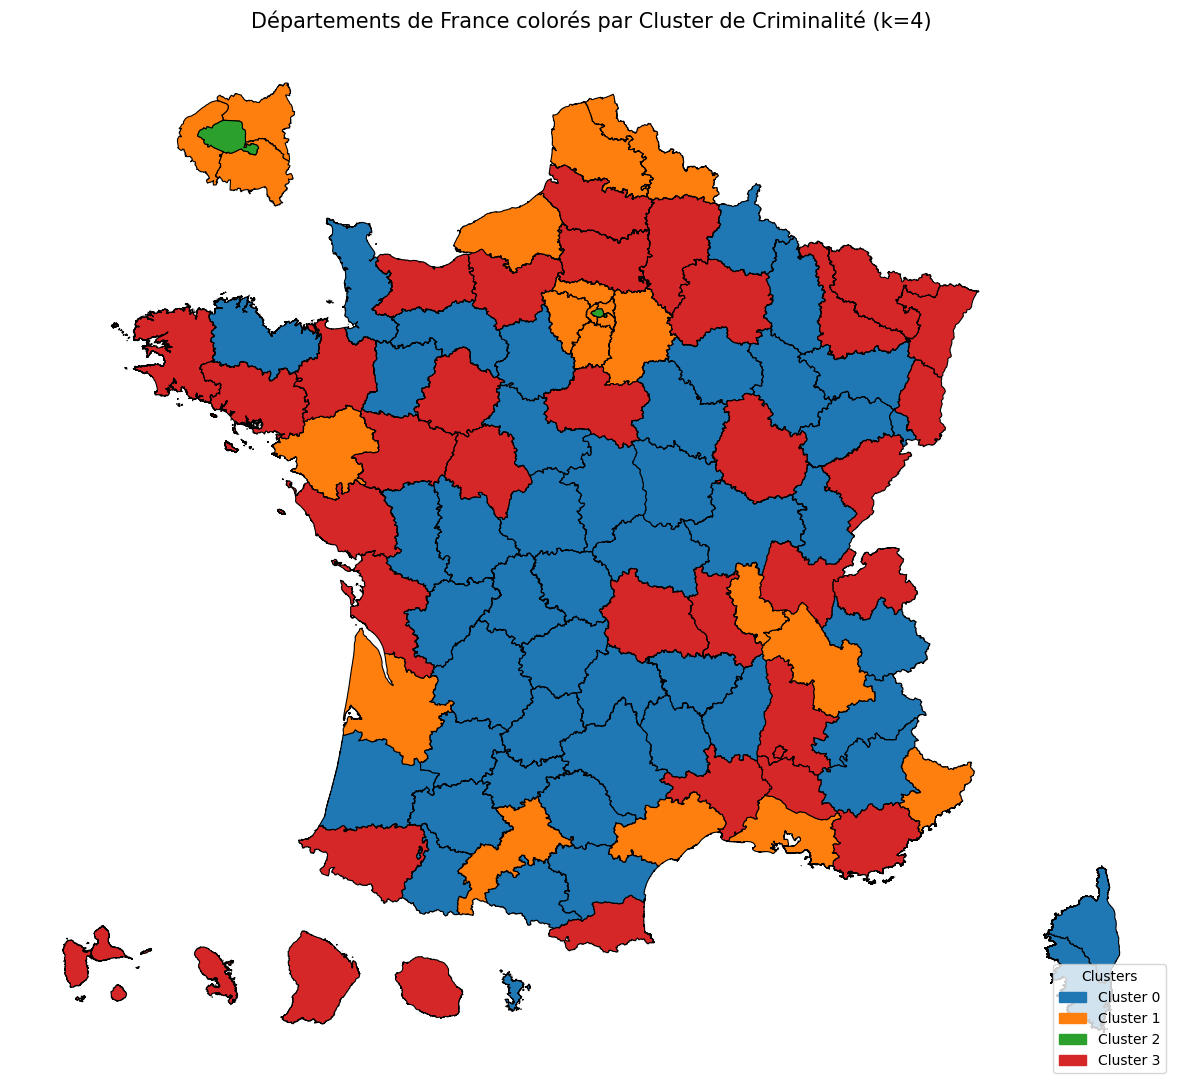

In [17]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

fig, ax = plt.subplots(1, 1, figsize=(15, 15))

cmap = plt.get_cmap('tab10')
n_clusters = len(merged_weighted_crime_2019['cluster'].unique())
colors = [cmap(i) for i in range(n_clusters)]

legend_patches = []

for cluster_id in sorted(merged_weighted_crime_2019['cluster'].unique()):
    subset = merged_weighted_crime_2019[merged_weighted_crime_2019['cluster'] == cluster_id]
    subset.plot(
        ax=ax,
        color=colors[cluster_id], # Assigne une couleur basée sur l'ID du cluster
        linewidth=0.8,
        edgecolor='black'
    )
    legend_patches.append(mpatches.Patch(color=colors[cluster_id], label=f'Cluster {cluster_id}'))

ax.set_title(f"Départements de France colorés par Cluster de Criminalité (k={k})", fontsize=15)
ax.set_axis_off()
ax.legend(handles=legend_patches, title="Clusters", loc='lower right')
plt.show()